In [3021]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [3022]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [3023]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [3024]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 1.68
ss.ell = 55.87
ss.w = 1.66
ss.K = 85.47
ss.I = 8.55
ss.Y = 105.85
ss.G = 26.46
ss.B_G = 0.00
ss.tau = 0.31
solving for household behavior: result.converged = True
ss.C = 61.78
ss.B = -11.33
ss.C_M = 12.87
ss.C_Y = 30.03
ss.C_E = 18.90
ss.C_G = 42.90
ss.C-ss.C_E-ss.C_G = -0.02
ss.X = nan
ss.M = nan
par.phi = 0.944


**Household behavior:**

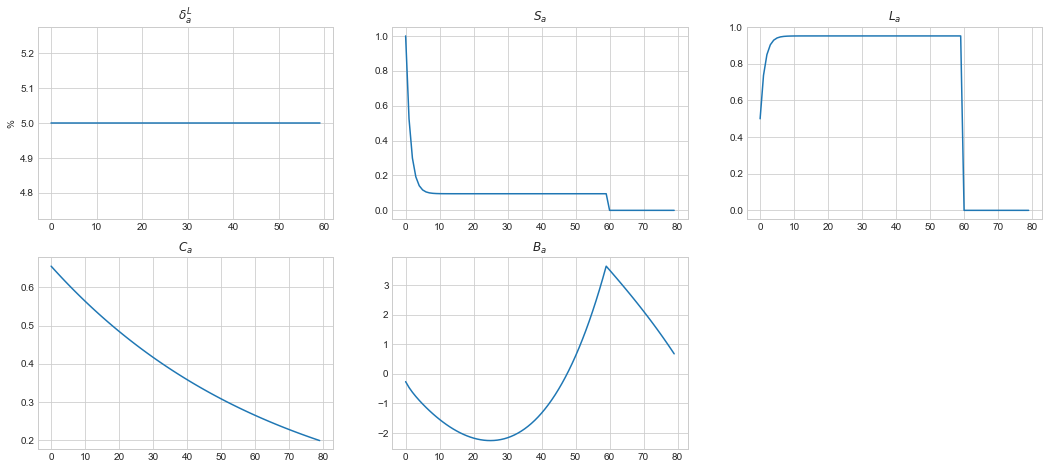

In [3025]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

In [3026]:
ss.P_C

1.077459354331014

# Speed and error tests

In [3027]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [3028]:
%time model.evaluate_blocks(py=True)

CPU times: user 1.72 s, sys: 210 ms, total: 1.93 s
Wall time: 2.27 s


**Check errors:**

In [3029]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 6.66e-16
Bq_match            : abs. max = 5.80e-12
FOC_capital_agency  : abs. max = 2.22e-16
FOC_K_ell           : abs. max = 6.66e-16
mkt_clearing        : abs. max = 9.95e-14
repacking_prices_C  : abs. max = 4.44e-16


**First numba evaluation:**

In [3030]:
%time model.evaluate_blocks()

CPU times: user 21.1 s, sys: 879 ms, total: 22 s
Wall time: 22.7 s


**Time:**

In [3031]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

5.07 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
28.4 µs ± 522 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3032]:
%timeit model.evaluate_blocks(py=True)

183 ms ± 5.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Find an impulse-response

**Calculate Jacobian:**

In [3033]:
model.calc_jac(do_print=True)

Jacobian calculated in 12.8 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [3057]:
model.set_exo_ss()

Here we shock export demand:

In [3058]:
# Tshock = 50
# shock = 0.01*ss.chi
# persistence = 0.8**np.arange(Tshock)
# sol.chi[:Tshock] = ss.chi + shock*persistence

Here we shock the import price of consumption goods (P_M_C):

In [3059]:
#Tshock = 60
#shock = 0.1*ss.P_M_C
#persistence = 0.85**np.arange(Tshock)
#sol.P_M_C[:Tshock] = ss.P_M_C + shock*persistence

In [3060]:
# def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        # shock_f = shock_size
        # persistence_f = persistence_size ** np.arange(time_span)
        # solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [3061]:
# guide: shock_func(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8)
# shock_func_ny(ss.tau,sol.tau, shock_size = -0.1, persistence_size =0.5)

In [3062]:
Tshock_1 = 15
#Tshock_2 = 60
shock_1 = 0.2*ss.P_E_C
#shock_2 = 0.2*ss.P_M_C
persistence_1 = 0.90**np.arange(Tshock_1)
#persistence_2 = 0.85**np.arange(Tshock_2-Tshock_1)
sol.P_M_C[:Tshock_1] = ss.P_E_C + shock_1*persistence_1
#sol.P_M_C[Tshock_1:Tshock_2] += shock_2*persistence_2


Check errors when guessing at steady state -> excess demand

In [3063]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 1.11e-15
Bq_match            : abs. max = 5.80e-12
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 6.66e-16
mkt_clearing        : abs. max = 8.53e-14
repacking_prices_C  : abs. max = 5.59e-02


**Find IRF:**

In [3064]:
model.find_IRF()

initial:
   max. abs. error = 5.59e-02
    1.11e-15 in bargaining_cond
    5.80e-12 in Bq_match
    0.00e+00 in FOC_capital_agency
    6.66e-16 in FOC_K_ell
    8.53e-14 in mkt_clearing
    5.59e-02 in repacking_prices_C

it = 0
 solve: t1-t0 = 0.2 secs
   max. abs. error = 5.59e-02
    1.47e-05 in bargaining_cond
    7.56e-04 in Bq_match
    1.15e-05 in FOC_capital_agency
    5.61e-06 in FOC_K_ell
    4.63e-03 in mkt_clearing
    1.21e-03 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 1
 solve: t1-t0 = 0.2 secs
   max. abs. error = 4.63e-03
    4.53e-07 in bargaining_cond
    2.65e-05 in Bq_match
    1.13e-07 in FOC_capital_agency
    1.66e-07 in FOC_K_ell
    5.94e-05 in mkt_clearing
    1.21e-05 in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.0 secs

it = 2
 solve: t1-t0 = 0.1 secs
   max. abs. error = 5.94e-05
    9.24e-09 in bargaining_cond
    5.74e-07 in Bq_match
    1.25e-09 in FOC_capital_agency
    4.35e-09 in FO

**Plot:**

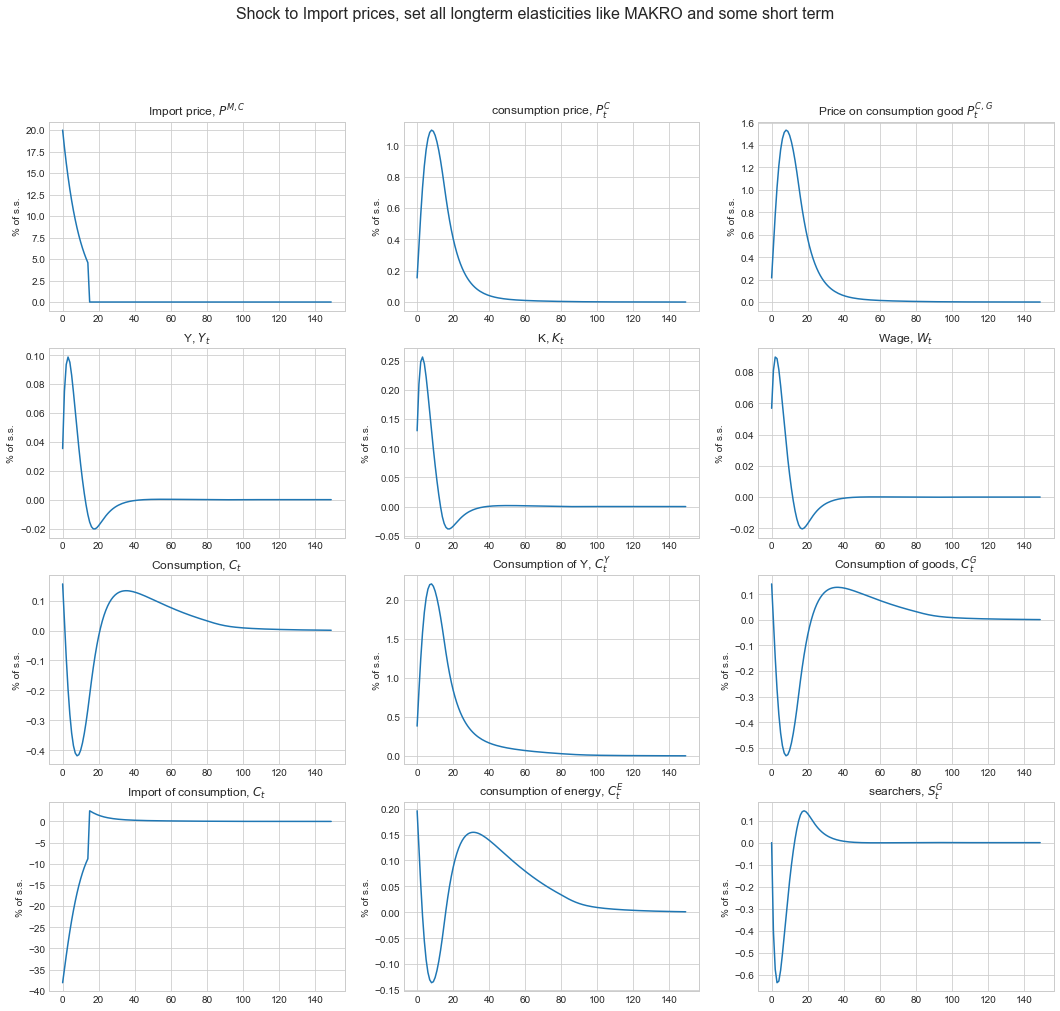

In [3065]:
T_IRF = 150

fig = plt.figure(figsize=(3*6,4*6/1.5))

fig.suptitle('Shock to Import prices, set all longterm elasticities like MAKRO and some short term', fontsize=16)

ax = fig.add_subplot(4,3,1)
ax.plot((sol.P_M_C[:T_IRF]/ss.P_E_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import price, $P^{M,C}$')

ax = fig.add_subplot(4,3,2)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('consumption price, $P^C_t$')

ax = fig.add_subplot(4,3,3)
ax.plot((sol.P_C_G[:T_IRF]/ss.P_C_G-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Price on consumption good $P^{C,G}_t$')

ax = fig.add_subplot(4,3,4)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Y, $Y_t$')

ax = fig.add_subplot(4,3,5)
ax.plot(((sol.K[:T_IRF])/(ss.K)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('K, $K_t$');

ax = fig.add_subplot(4,3,6)
ax.plot(((sol.L[:T_IRF])/(ss.L)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Wage, $W_t$');

ax = fig.add_subplot(4,3,7)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,3,8)
ax.plot(((sol.C_Y[:T_IRF])/(ss.C_Y)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption of Y, $C^Y_t$');

ax = fig.add_subplot(4,3,9)
ax.plot(((sol.C_G[:T_IRF])/(ss.C_G)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption of goods, $C^G_t$');


ax = fig.add_subplot(4,3, 10)
ax.plot((sol.C_M[:T_IRF]/ss.C_M-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Import of consumption, $C_t$')

ax = fig.add_subplot(4,3,11)
ax.plot(((sol.C_E[:T_IRF])/(ss.C_E)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('consumption of energy, $C^E_t$');

ax = fig.add_subplot(4,3,12)
ax.plot(((sol.S[:T_IRF])/(ss.S)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('searchers, $S^G_t$');
